In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime


In [2]:
# Load the processed dataset
df = pd.read_csv("../../dataset/processed/merged_gold_macro_final_20250331_170349.csv", parse_dates=["Date"])

# Make sure it's sorted
df.sort_values("Date", inplace=True)

# Holdout test data (2024)
test_df = df[df["Date"] >= "2024-01-01"].copy()

# Train + Validation data (2012–2023)
trainval_df = df[df["Date"] < "2024-01-01"].copy()


In [3]:
# 80% train, 20% validation
train_size = int(len(trainval_df) * 0.8)
train_df = trainval_df.iloc[:train_size]
val_df = trainval_df.iloc[train_size:]

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size (2024):", len(test_df))


Train size: 2010
Validation size: 503
Test size (2024): 251


In [4]:
# ADF Test on training Adj_Close
result = adfuller(train_df["Adj_Close"].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")
    
if result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("❌ Series is non-stationary")


ADF Statistic: -0.5347060385919621
p-value: 0.8850640722944025
Critical Value 1%: -3.4336189466940414
Critical Value 5%: -2.8629840458358933
Critical Value 10%: -2.5675387480760885
❌ Series is non-stationary


In [5]:
# --- Since it's non-stationary, apply first-order differencing ---
train_df = train_df.copy()  # Avoid SettingWithCopyWarning
train_df["Adj_Close_diff"] = train_df["Adj_Close"].diff()
train_diff = train_df.dropna(subset=["Adj_Close_diff"])

# Re-run ADF test on differenced series
result_diff = adfuller(train_diff["Adj_Close_diff"])

print("ADF Statistic (1st diff):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f"Critical Value {key}: {value}")

if result_diff[1] <= 0.05:
    print("✅ Differenced series is stationary")
else:
    print("❌ Still non-stationary – consider second-order differencing")


ADF Statistic (1st diff): -20.195364885143093
p-value: 0.0
Critical Value 1%: -3.4336189466940414
Critical Value 5%: -2.8629840458358933
Critical Value 10%: -2.5675387480760885
✅ Differenced series is stationary


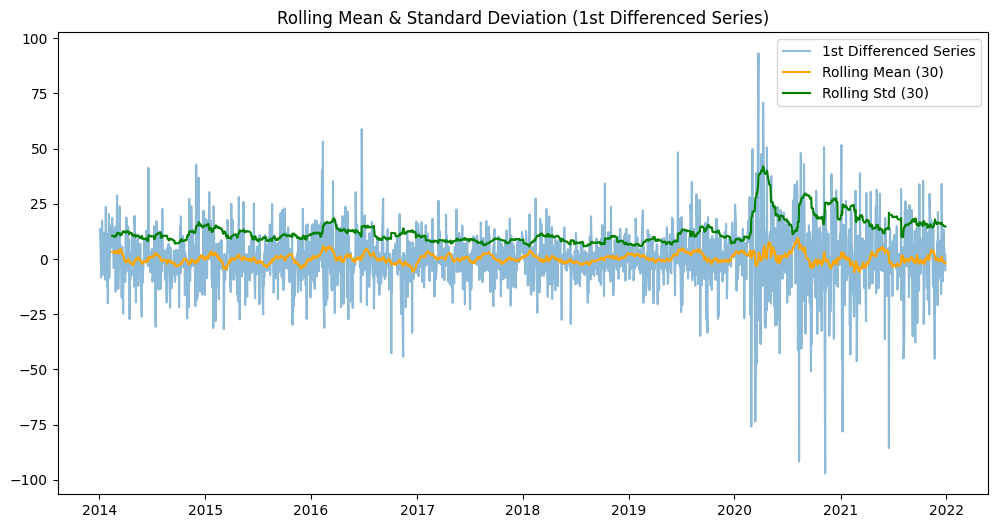

In [6]:
# Plot rolling mean and std for differenced series
rolling_mean_diff = train_diff["Adj_Close_diff"].rolling(window=30).mean()
rolling_std_diff = train_diff["Adj_Close_diff"].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(train_diff["Date"], train_diff["Adj_Close_diff"], label="1st Differenced Series", alpha=0.5)
plt.plot(train_diff["Date"], rolling_mean_diff, label="Rolling Mean (30)", color="orange")
plt.plot(train_diff["Date"], rolling_std_diff, label="Rolling Std (30)", color="green")
plt.title("Rolling Mean & Standard Deviation (1st Differenced Series)")
plt.legend()
plt.show()


In [7]:
import pandas as pd
from pathlib import Path

def save_model_results(model_name, parameters, exog_features, mae, rmse, r2, notes="", csv_path="../../results/model_metrics_log.csv"):
    result = pd.DataFrame([{
        "Model": model_name,
        "Parameters": parameters,
        "Exogenous_Features": exog_features,
        "MAE": mae,
        "RMSE": rmse,
        "R2_Score": r2,
        "Notes": notes
    }])

    # Create folder if it doesn't exist
    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    # Append to CSV or create new
    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, result], ignore_index=True)
    except FileNotFoundError:
        updated = result

    updated.to_csv(csv_path, index=False)
    print(f"✅ Saved model result to: {csv_path}")

In [8]:
def save_forecast_results(dates, actual, forecast, model_name, csv_path="../../results/model_forecasts_log.csv"):
    forecast_df = pd.DataFrame({
        "Date": dates,
        "Actual": actual,
        "Forecast": forecast,
        "Model": model_name
    })

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, forecast_df], ignore_index=True)
    except FileNotFoundError:
        updated = forecast_df

    updated.to_csv(csv_path, index=False)
    print(f"📈 Saved forecast data for {model_name} to: {csv_path}")



=== ARIMA (Univariate) Evaluation on 2024 ===
MAE: 338.07
RMSE: 395.37
R² Score: -2.1339


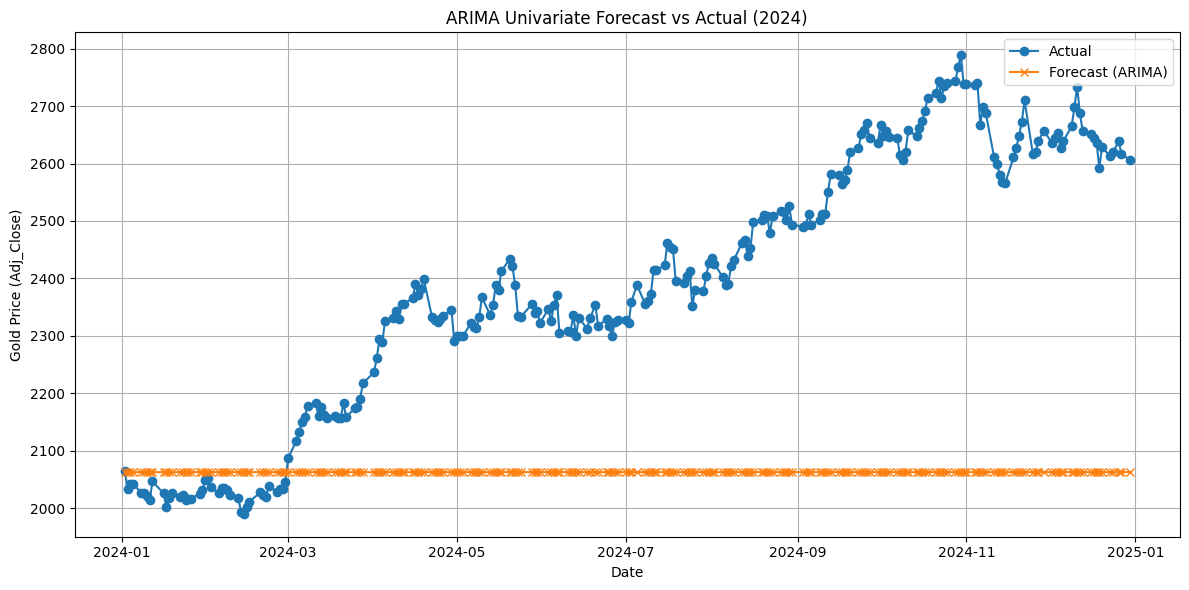

✅ Saved model result to: ../../results/model_metrics_log.csv


/var/folders/7t/rbz52wf53sl7c0gh0xqvhs2m0000gn/T/ipykernel_50639/1259988110.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  updated = pd.concat([existing, result], ignore_index=True)


In [9]:
# --- ARIMA (Univariate) Model Training and Forecasting ---

# Re-fit model on full trainval period (2012–2023) using original Adj_Close
full_train = trainval_df["Adj_Close"]

# Fit ARIMA(p,d,q) — we'll start with (1,1,1)
arima_model = ARIMA(full_train, order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast for 2024
n_test_steps = len(test_df)
arima_forecast = arima_result.forecast(steps=n_test_steps)

# --- Evaluation ---
y_true = test_df["Adj_Close"].values
y_pred = arima_forecast.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n=== ARIMA (Univariate) Evaluation on 2024 ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred, label="Forecast (ARIMA)", marker="x")
plt.title("ARIMA Univariate Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save ARIMA results
save_model_results(
    model_name="ARIMA",
    parameters="(1,1,1)",
    exog_features="None",
    mae=mae,
    rmse=rmse,
    r2=r2,
    notes="Univariate ARIMA on Adj_Close"
)

In [10]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true,
    forecast=y_pred,
    model_name="ARIMA"
)


📈 Saved forecast data for ARIMA to: ../../results/model_forecasts_log.csv



=== SARIMA Evaluation on 2024 ===
MAE: 299.51
RMSE: 349.19
R² Score: -1.4445


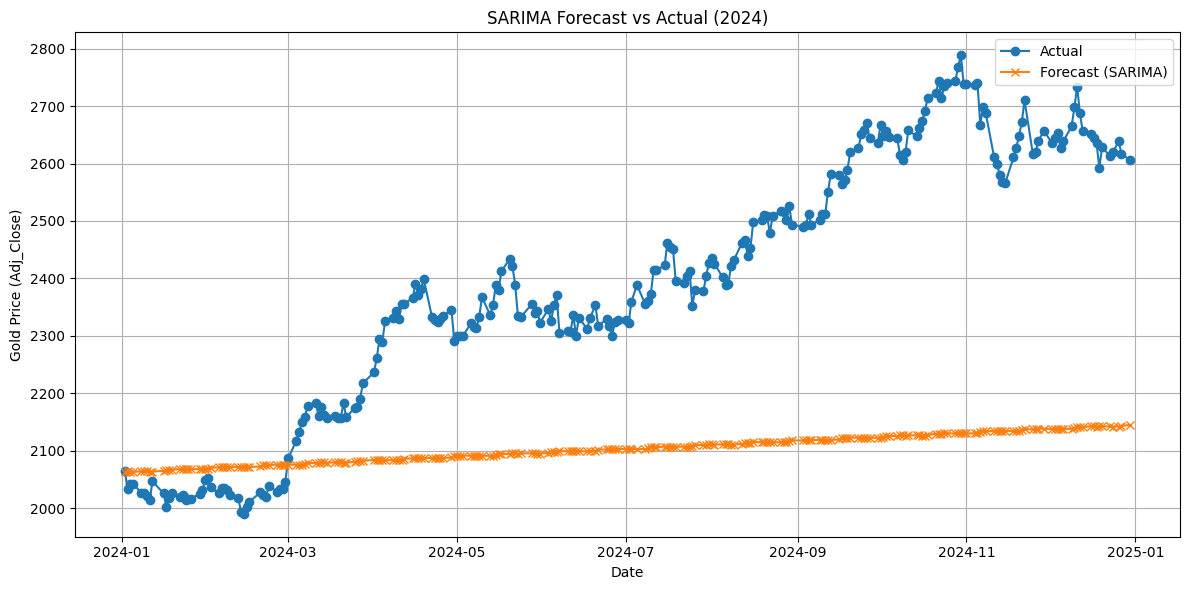

✅ Saved model result to: ../../results/model_metrics_log.csv


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- SARIMA Model ---
# We'll use (p,d,q)x(P,D,Q,s) = (1,1,1)x(1,1,1,12) as a starting point for annual seasonality

sarima_model = SARIMAX(
    full_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)

# Forecast for the test period (2024)
sarima_forecast = sarima_result.forecast(steps=n_test_steps)

# --- Evaluation ---
y_pred_sarima = sarima_forecast.values

mae_sarima = mean_absolute_error(y_true, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true, y_pred_sarima))
r2_sarima = r2_score(y_true, y_pred_sarima)

print("\n=== SARIMA Evaluation on 2024 ===")
print(f"MAE: {mae_sarima:.2f}")
print(f"RMSE: {rmse_sarima:.2f}")
print(f"R² Score: {r2_sarima:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred_sarima, label="Forecast (SARIMA)", marker="x")
plt.title("SARIMA Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save SARIMA results
save_model_results(
    model_name="SARIMA",
    parameters="(1,1,1)x(1,1,1,12)",
    exog_features="None",
    mae=mae_sarima,
    rmse=rmse_sarima,
    r2=r2_sarima,
    notes="Univariate SARIMA with annual seasonality"
)


In [12]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true,
    forecast=y_pred_sarima,
    model_name="SARIMA"
)


📈 Saved forecast data for SARIMA to: ../../results/model_forecasts_log.csv



=== ARIMAX Evaluation on 2024 ===
MAE: 372.70
RMSE: 433.23
R² Score: -2.7628


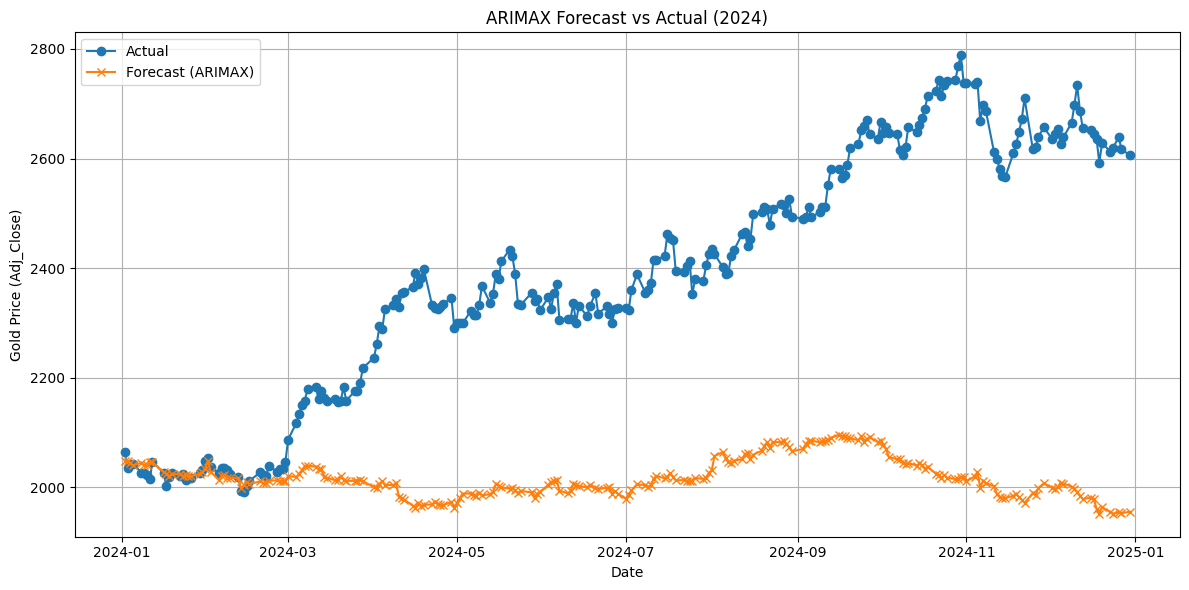

✅ Saved model result to: ../../results/model_metrics_log.csv


In [13]:
# --- ARIMAX Model (ARIMA + Exogenous Features) ---

# Select exogenous features (can be fine-tuned later)
exog_cols = ["USD_Index", "CPI", "Yield_10Y", "headline_count", "avg_sentiment"]
exog_train = trainval_df[exog_cols]
exog_test = test_df[exog_cols]

# Fit ARIMAX using SARIMAX with no seasonality
arimax_model = SARIMAX(
    trainval_df["Adj_Close"],
    exog=exog_train,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_result = arimax_model.fit(disp=False)

# Forecast with exogenous variables
arimax_forecast = arimax_result.forecast(steps=len(test_df), exog=exog_test)

# --- Evaluation ---
y_pred_arimax = arimax_forecast.values
mae_arimax = mean_absolute_error(y_true, y_pred_arimax)
rmse_arimax = np.sqrt(mean_squared_error(y_true, y_pred_arimax))
r2_arimax = r2_score(y_true, y_pred_arimax)

print("\n=== ARIMAX Evaluation on 2024 ===")
print(f"MAE: {mae_arimax:.2f}")
print(f"RMSE: {rmse_arimax:.2f}")
print(f"R² Score: {r2_arimax:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred_arimax, label="Forecast (ARIMAX)", marker="x")
plt.title("ARIMAX Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save model results ---
save_model_results(
    model_name="ARIMAX",
    parameters="(1,1,1)",
    exog_features=", ".join(exog_cols),
    mae=mae_arimax,
    rmse=rmse_arimax,
    r2=r2_arimax,
    notes="ARIMAX using SARIMAX(no seasonality)"
)


In [14]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true,
    forecast=y_pred_arimax,
    model_name="ARIMAX"
)


📈 Saved forecast data for ARIMAX to: ../../results/model_forecasts_log.csv


/opt/anaconda3/envs/gold-prediction/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== SARIMAX (with Exogenous) Evaluation on 2024 ===
MAE: 326.11
RMSE: 378.94
R² Score: -1.8788


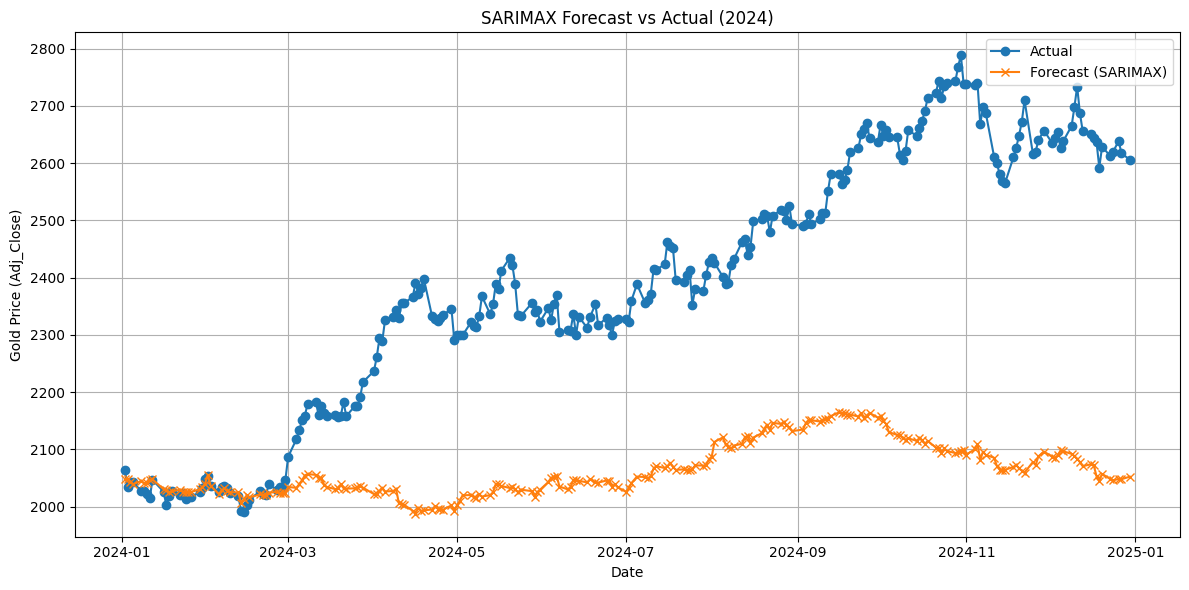

✅ Saved model result to: ../../results/model_metrics_log.csv


In [15]:
# --- SARIMAX (Multivariate) with Exogenous Features ---

# Define exogenous variables (you can tweak which ones to include)
exog_features = ["USD_Index", "CPI", "Yield_10Y", "avg_sentiment"]

# Prepare exogenous data
exog_trainval = trainval_df[exog_features].copy()
exog_test = test_df[exog_features].copy()

# Fit SARIMAX model
sarimax_model = SARIMAX(
    trainval_df["Adj_Close"],
    exog=exog_trainval,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast for 2024 using test exogenous features
sarimax_forecast = sarimax_result.forecast(steps=len(test_df), exog=exog_test)

# Evaluation
y_pred_sarimax = sarimax_forecast.values
mae_sarimax = mean_absolute_error(y_true, y_pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_true, y_pred_sarimax))
r2_sarimax = r2_score(y_true, y_pred_sarimax)

print("\n=== SARIMAX (with Exogenous) Evaluation on 2024 ===")
print(f"MAE: {mae_sarimax:.2f}")
print(f"RMSE: {rmse_sarimax:.2f}")
print(f"R² Score: {r2_sarimax:.4f}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred_sarimax, label="Forecast (SARIMAX)", marker="x")
plt.title("SARIMAX Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save SARIMAX results
save_model_results(
    model_name="SARIMAX",
    parameters="(1,1,1)x(1,1,1,12)",
    exog_features=", ".join(exog_features),
    mae=mae_sarimax,
    rmse=rmse_sarimax,
    r2=r2_sarimax,
    notes="SARIMAX with CPI, USD, Yield, and Sentiment"
)


In [16]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true,
    forecast=y_pred_sarimax,
    model_name="SARIMAX"
)


📈 Saved forecast data for SARIMAX to: ../../results/model_forecasts_log.csv


/opt/anaconda3/envs/gold-prediction/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:26:34 - cmdstanpy - INFO - Chain [1] start processing
22:26:34 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet (Univariate) Evaluation on 2024 ===
MAE: 380.92
RMSE: 436.12
R² Score: -2.8132


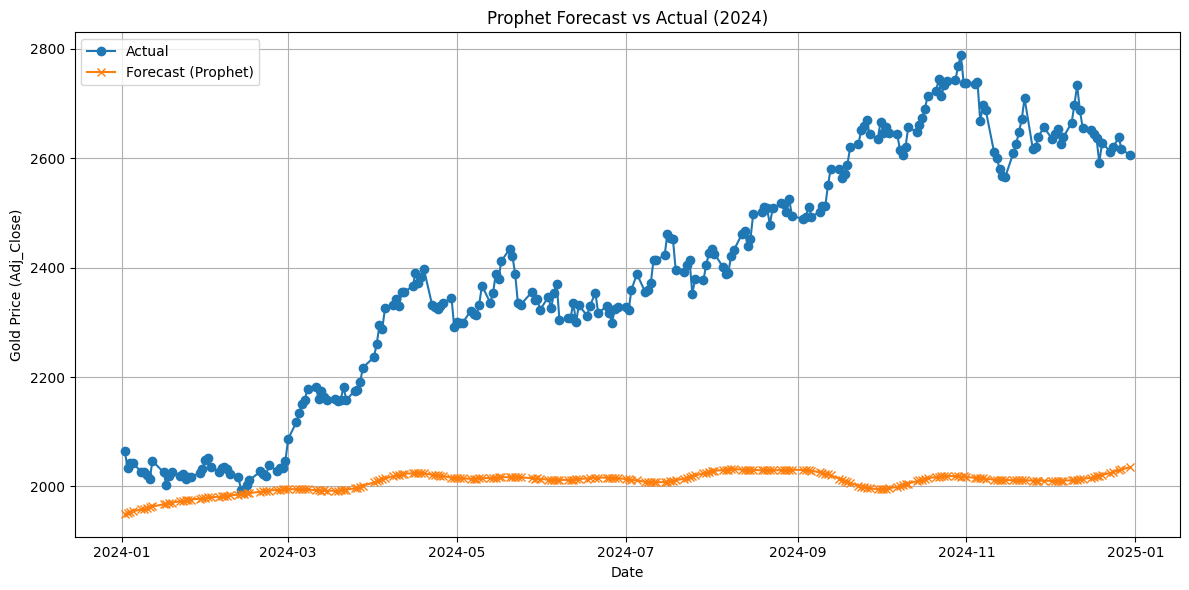

✅ Saved model result to: ../../results/model_metrics_log.csv


In [17]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Prepare data for Prophet ---
prophet_df = trainval_df[["Date", "Adj_Close"]].rename(columns={"Date": "ds", "Adj_Close": "y"})

# --- Fit Prophet Model ---
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df)

# --- Create future DataFrame for 2024 ---
future_dates = test_df[["Date"]].rename(columns={"Date": "ds"})

# --- Forecast ---
prophet_forecast = prophet_model.predict(future_dates)

# --- Evaluation ---
y_true = test_df["Adj_Close"].values
y_pred = prophet_forecast["yhat"].values

mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
r2_prophet = r2_score(y_true, y_pred)

print("\n=== Prophet (Univariate) Evaluation on 2024 ===")
print(f"MAE: {mae_prophet:.2f}")
print(f"RMSE: {rmse_prophet:.2f}")
print(f"R² Score: {r2_prophet:.4f}")

# --- Plot forecast vs actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred, label="Forecast (Prophet)", marker="x")
plt.title("Prophet Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save results ---
save_model_results(
    model_name="Prophet",
    parameters="default (daily_seasonality=True)",
    exog_features="None",
    mae=mae_prophet,
    rmse=rmse_prophet,
    r2=r2_prophet,
    notes="Univariate Prophet"
)


In [18]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true,
    forecast=y_pred,
    model_name="Prophet"
)


📈 Saved forecast data for Prophet to: ../../results/model_forecasts_log.csv


22:26:35 - cmdstanpy - INFO - Chain [1] start processing
22:26:35 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet with Exogenous Features Evaluation ===
MAE: 272.19
RMSE: 318.67
R² Score: -1.0359


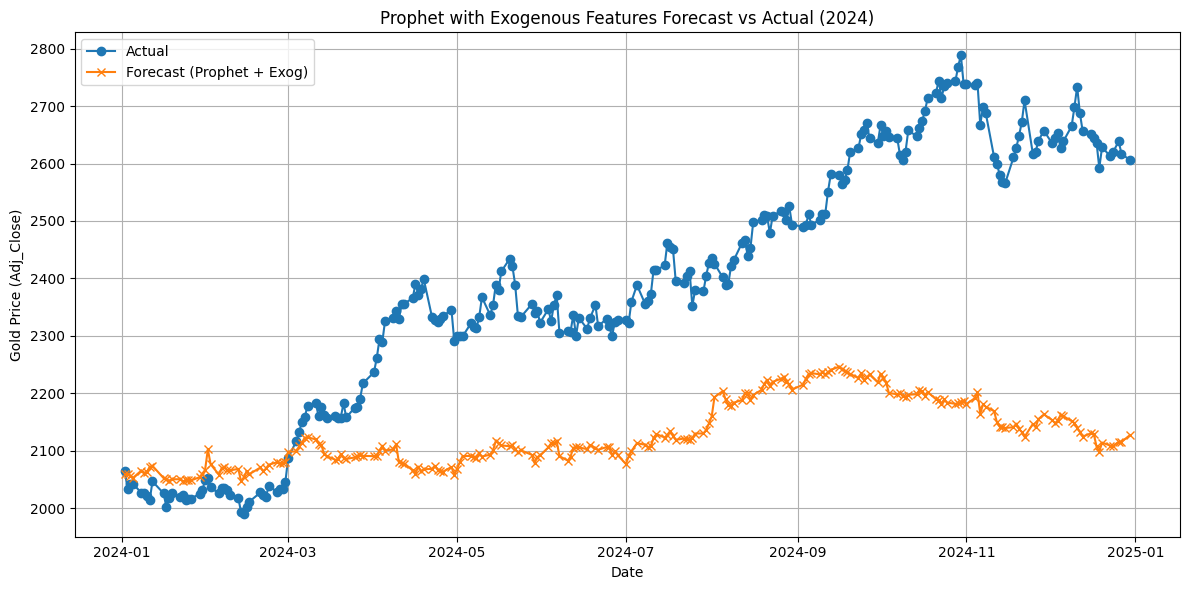

✅ Saved model result to: ../../results/model_metrics_log.csv


In [19]:
# Regressors to include
regressors = ["USD_Index", "CPI", "Yield_10Y", "headline_count", "avg_sentiment"]

# Prepare training set for Prophet
prophet_train_exog = trainval_df[["Date", "Adj_Close"] + regressors].rename(columns={"Date": "ds", "Adj_Close": "y"})

# Prepare test set for future prediction
prophet_test_exog = test_df[["Date"] + regressors].rename(columns={"Date": "ds"})

# Initialize Prophet model with regressors
prophet_exog = Prophet(daily_seasonality=True)

# Add regressors
for reg in regressors:
    prophet_exog.add_regressor(reg)

# Fit the model
prophet_exog.fit(prophet_train_exog)

# Forecast using test set regressors
forecast_exog = prophet_exog.predict(prophet_test_exog)

# Evaluation
y_true_exog = test_df["Adj_Close"].values
y_pred_exog = forecast_exog["yhat"].values

mae_exog = mean_absolute_error(y_true_exog, y_pred_exog)
rmse_exog = np.sqrt(mean_squared_error(y_true_exog, y_pred_exog))
r2_exog = r2_score(y_true_exog, y_pred_exog)

print("\n=== Prophet with Exogenous Features Evaluation ===")
print(f"MAE: {mae_exog:.2f}")
print(f"RMSE: {rmse_exog:.2f}")
print(f"R² Score: {r2_exog:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_df["Date"], y_true_exog, label="Actual", marker="o")
plt.plot(test_df["Date"], y_pred_exog, label="Forecast (Prophet + Exog)", marker="x")
plt.title("Prophet with Exogenous Features Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

save_model_results(
    model_name="Prophet",
    parameters="daily_seasonality=True",
    exog_features=", ".join(regressors),
    mae=mae_exog,
    rmse=rmse_exog,
    r2=r2_exog,
    notes="Prophet with exogenous features"
)



In [20]:
save_forecast_results(
    dates=test_df["Date"],
    actual=y_true_exog,
    forecast=y_pred_exog,
    model_name="Prophet + Exog"
)


📈 Saved forecast data for Prophet + Exog to: ../../results/model_forecasts_log.csv
